# Book Orders Data Analysis

This notebook analyzes book order data from three different data folders (DATA1, DATA2, DATA3).

## Tasks:
1. Load and clean data from each folder
2. Compute daily revenue and find top 5 days
3. Find unique users (reconciling aliases/changed fields)
4. Find unique author sets
5. Find most popular author(s)
6. Identify top customer by spending
7. Plot daily revenue charts

## 1. Import Required Libraries

In [7]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Base path for data folders
BASE_PATH = 'data'
DATA_FOLDERS = ['DATA1', 'DATA2', 'DATA3']

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Define Analysis Functions

Create reusable functions for data loading, cleaning, and analysis.

In [8]:
from dateutil import parser as date_parser
import re

def load_users(folder_path):
    """Load and clean users data from CSV file."""
    users_df = pd.read_csv(f'{folder_path}/users.csv')
    
    # Replace NULL strings with NaN
    users_df.replace('NULL', np.nan, inplace=True)
    users_df.replace(' ', np.nan, inplace=True)
    users_df.replace('', np.nan, inplace=True)
    
    # Strip whitespace from string columns
    for col in ['name', 'address', 'phone', 'email']:
        if col in users_df.columns:
            users_df[col] = users_df[col].astype(str).str.strip()
            users_df[col] = users_df[col].replace('nan', np.nan)
    
    # Remove exact duplicates
    users_df = users_df.drop_duplicates()
    
    print(f"Loaded {len(users_df)} users from {folder_path}")
    return users_df


def load_books(folder_path):
    """Load and clean books data from YAML file."""
    with open(f'{folder_path}/books.yaml', 'r') as f:
        books_data = yaml.safe_load(f)
    
    # Convert to DataFrame
    books_df = pd.DataFrame(books_data)
    
    # Rename columns (remove Ruby-style symbols)
    books_df.columns = [col.replace(':', '') for col in books_df.columns]
    
    # Clean data
    books_df['publisher'] = books_df['publisher'].replace(' ', np.nan)
    books_df['year'] = pd.to_numeric(books_df['year'], errors='coerce')
    
    # Remove duplicates
    books_df = books_df.drop_duplicates()
    
    print(f"Loaded {len(books_df)} books from {folder_path}")
    return books_df


def parse_price(price_str):
    """
    Parse price string in various formats and convert to USD.
    Formats: '27.00$', '€50¢50', 'USD 45.99', '€ 71.00', '52.25 $', '22$75¢'
    EUR to USD rate: €1 = $1.2
    """
    if pd.isna(price_str):
        return np.nan
    
    price_str = str(price_str).strip()
    
    # Determine currency
    is_euro = '€' in price_str or 'EUR' in price_str.upper()
    
    # Handle special case: XX$YY¢ or €XX¢YY format (dollars/euros and cents separately)
    # Pattern: number followed by $ or €, then optionally number followed by ¢
    if '¢' in price_str:
        # Try to extract main value and cents
        # Formats like: 22$75¢, €50¢50
        main_value = 0
        cents_value = 0
        
        # Extract number before currency symbol
        parts = re.split(r'[\$€¢]', price_str)
        parts = [p.strip() for p in parts if p.strip()]
        
        if len(parts) >= 1:
            try:
                main_value = float(parts[0])
            except:
                main_value = 0
        
        if len(parts) >= 2:
            try:
                cents_value = float(parts[1])
            except:
                cents_value = 0
        
        value = main_value + cents_value / 100
    else:
        # Remove currency symbols and extract number
        cleaned = price_str.replace('€', '').replace('$', '').replace('USD', '').replace('EUR', '').strip()
        try:
            value = float(cleaned)
        except:
            value = 0
    
    # Convert EUR to USD
    if is_euro:
        value = value * 1.2
    
    return round(value, 2)


def parse_timestamp(ts_str):
    """
    Parse timestamp string in various formats using dateutil parser.
    """
    if pd.isna(ts_str):
        return pd.NaT
    
    ts_str = str(ts_str).strip()
    
    # Clean common variations
    ts_clean = ts_str.replace('A.M.', 'AM').replace('P.M.', 'PM')
    ts_clean = ts_clean.replace('a.m.', 'AM').replace('p.m.', 'PM')
    ts_clean = ts_clean.replace(';', ' ').replace(',', ' ')
    
    try:
        return date_parser.parse(ts_clean, fuzzy=True)
    except:
        pass
    
    return pd.NaT


def load_orders(folder_path):
    """Load and clean orders data from Parquet file."""
    orders_df = pd.read_parquet(f'{folder_path}/orders.parquet')
    
    # Parse unit_price (handle various currency formats)
    orders_df['unit_price_usd'] = orders_df['unit_price'].apply(parse_price)
    
    # Parse timestamp using dateutil
    print("Parsing timestamps (this may take a moment)...")
    orders_df['timestamp_parsed'] = orders_df['timestamp'].apply(parse_timestamp)
    
    # Convert to proper datetime
    orders_df['timestamp_parsed'] = pd.to_datetime(orders_df['timestamp_parsed'], errors='coerce')
    
    # Ensure numeric columns
    orders_df['quantity'] = pd.to_numeric(orders_df['quantity'], errors='coerce')
    
    # Remove duplicates
    orders_df = orders_df.drop_duplicates()
    
    print(f"Loaded {len(orders_df)} orders from {folder_path}")
    print(f"  - Successfully parsed prices: {orders_df['unit_price_usd'].notna().sum()}")
    print(f"  - Successfully parsed timestamps: {orders_df['timestamp_parsed'].notna().sum()}")
    
    return orders_df


def add_paid_price(orders_df):
    """
    Add paid_price column: quantity * unit_price (already in USD)
    """
    orders_df['paid_price'] = orders_df['quantity'] * orders_df['unit_price_usd']
    orders_df['paid_price'] = orders_df['paid_price'].round(2)
    
    return orders_df


def extract_date(orders_df):
    """Extract date (year, month, day) from parsed timestamp."""
    orders_df['date'] = orders_df['timestamp_parsed'].dt.date
    orders_df['year'] = orders_df['timestamp_parsed'].dt.year
    orders_df['month'] = orders_df['timestamp_parsed'].dt.month
    orders_df['day'] = orders_df['timestamp_parsed'].dt.day
    
    return orders_df


def compute_daily_revenue(orders_df):
    """Compute daily revenue and find top 5 days."""
    # Filter out rows with missing dates or prices
    valid_orders = orders_df.dropna(subset=['date', 'paid_price'])
    
    daily_revenue = valid_orders.groupby('date')['paid_price'].sum().reset_index()
    daily_revenue.columns = ['date', 'revenue']
    daily_revenue = daily_revenue.sort_values('date')
    
    top_5_days = daily_revenue.nlargest(5, 'revenue').copy()
    top_5_days['date'] = pd.to_datetime(top_5_days['date']).dt.strftime('%Y-%m-%d')
    
    return daily_revenue, top_5_days


print("Data loading functions defined!")

Data loading functions defined!


In [9]:
def normalize_phone(phone):
    """Normalize phone number by removing all non-digit characters."""
    if pd.isna(phone) or phone == 'nan':
        return None
    return ''.join(filter(str.isdigit, str(phone)))


def reconcile_users(users_df):
    """
    Reconcile users by finding those who are the same person but with different fields.
    Uses Union-Find algorithm to group users that share at least 3 out of 4 fields
    (assuming only one field is changed at a time).
    """
    users_df = users_df.copy()
    
    # Normalize phone numbers for comparison
    users_df['phone_normalized'] = users_df['phone'].apply(normalize_phone)
    
    # Create normalized email (lowercase)
    users_df['email_normalized'] = users_df['email'].str.lower().str.strip()
    
    n = len(users_df)
    
    # Union-Find data structure
    parent = list(range(n))
    
    def find(x):
        if parent[x] != x:
            parent[x] = find(parent[x])
        return parent[x]
    
    def union(x, y):
        px, py = find(x), find(y)
        if px != py:
            parent[px] = py
    
    # Compare each pair of users
    for i in range(n):
        for j in range(i + 1, n):
            user_i = users_df.iloc[i]
            user_j = users_df.iloc[j]
            
            # Count matching fields (email is the most reliable identifier)
            matches = 0
            fields_compared = 0
            
            # Check email (most reliable)
            if pd.notna(user_i['email_normalized']) and pd.notna(user_j['email_normalized']):
                fields_compared += 1
                if user_i['email_normalized'] == user_j['email_normalized']:
                    matches += 1
                    # Same email = same person
                    union(i, j)
                    continue
            
            # Check phone
            if pd.notna(user_i['phone_normalized']) and pd.notna(user_j['phone_normalized']):
                fields_compared += 1
                if user_i['phone_normalized'] == user_j['phone_normalized']:
                    matches += 1
            
            # Check name (case-insensitive)
            if pd.notna(user_i['name']) and pd.notna(user_j['name']):
                fields_compared += 1
                if str(user_i['name']).lower().strip() == str(user_j['name']).lower().strip():
                    matches += 1
            
            # Check address
            if pd.notna(user_i['address']) and pd.notna(user_j['address']):
                fields_compared += 1
                if str(user_i['address']).strip() == str(user_j['address']).strip():
                    matches += 1
            
            # If at least 3 fields match (only one field changed), they're the same person
            if matches >= 3 and fields_compared >= 3:
                union(i, j)
            # If 2 fields match and one is email or phone (strong identifiers)
            elif matches >= 2 and fields_compared >= 2:
                # Check if phone OR email matches (strong identifier)
                phone_match = (pd.notna(user_i['phone_normalized']) and 
                              pd.notna(user_j['phone_normalized']) and
                              user_i['phone_normalized'] == user_j['phone_normalized'])
                email_match = (pd.notna(user_i['email_normalized']) and 
                              pd.notna(user_j['email_normalized']) and
                              user_i['email_normalized'] == user_j['email_normalized'])
                if phone_match or email_match:
                    union(i, j)
    
    # Group users by their root parent
    groups = defaultdict(list)
    for i in range(n):
        groups[find(i)].append(users_df.iloc[i]['id'])
    
    unique_users_count = len(groups)
    
    # Create mapping from user_id to group
    user_to_group = {}
    for group_id, user_ids in enumerate(groups.values()):
        for user_id in user_ids:
            user_to_group[user_id] = group_id
    
    return unique_users_count, groups, user_to_group


def find_unique_author_sets(books_df):
    """Find all unique sets of authors."""
    author_sets = set()
    
    for author_str in books_df['author'].dropna():
        # Split by comma and clean up
        authors = [a.strip() for a in str(author_str).split(',')]
        # Sort to ensure consistent ordering
        authors_tuple = tuple(sorted(authors))
        author_sets.add(authors_tuple)
    
    return len(author_sets), author_sets


def find_most_popular_author(orders_df, books_df):
    """Find the most popular author(s) by total books sold."""
    # Merge orders with books
    merged = orders_df.merge(books_df[['id', 'author']], left_on='book_id', right_on='id', how='left')
    
    # Count books sold per author set
    author_sales = merged.groupby('author')['quantity'].sum().reset_index()
    author_sales.columns = ['author', 'total_sold']
    
    # Find max
    max_sold = author_sales['total_sold'].max()
    most_popular = author_sales[author_sales['total_sold'] == max_sold]['author'].tolist()
    
    return most_popular, max_sold


def find_top_customer(orders_df, user_groups):
    """
    Find the top customer by total spending.
    Returns all user_ids associated with that customer.
    """
    # Calculate total spending per user_id
    user_spending = orders_df.groupby('user_id')['paid_price'].sum().reset_index()
    user_spending.columns = ['user_id', 'total_spending']
    
    # Map user_id to group
    user_to_group = {}
    for group_id, (root, user_ids) in enumerate(user_groups.items()):
        for user_id in user_ids:
            user_to_group[user_id] = group_id
    
    # Add group to spending
    user_spending['group'] = user_spending['user_id'].map(user_to_group)
    
    # Sum spending by group
    group_spending = user_spending.groupby('group')['total_spending'].sum().reset_index()
    
    # Find top group
    top_group = group_spending.loc[group_spending['total_spending'].idxmax(), 'group']
    top_spending = group_spending['total_spending'].max()
    
    # Get all user_ids for top group
    top_user_ids = sorted(user_spending[user_spending['group'] == top_group]['user_id'].tolist())
    
    return top_user_ids, top_spending


def plot_daily_revenue(daily_revenue, title="Daily Revenue"):
    """Plot daily revenue line chart."""
    fig, ax = plt.subplots(figsize=(14, 6))
    
    dates = pd.to_datetime(daily_revenue['date'])
    
    ax.plot(dates, daily_revenue['revenue'], linewidth=2, color='#2E86AB', marker='o', markersize=3)
    ax.fill_between(dates, daily_revenue['revenue'], alpha=0.3, color='#2E86AB')
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Revenue ($)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Format y-axis with dollar sign
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    return fig


print("Analysis functions defined!")

Analysis functions defined!


In [10]:
def analyze_dataset(folder_name):
    """
    Complete analysis for a single dataset folder.
    Returns all results needed for the dashboard.
    """
    folder_path = f'{BASE_PATH}/{folder_name}'
    
    print(f"\n{'='*60}")
    print(f"ANALYZING {folder_name}")
    print(f"{'='*60}\n")
    
    # Load data
    users_df = load_users(folder_path)
    books_df = load_books(folder_path)
    orders_df = load_orders(folder_path)
    
    # Process orders
    orders_df = add_paid_price(orders_df)
    orders_df = extract_date(orders_df)
    
    # 1. Daily Revenue & Top 5 Days
    daily_revenue, top_5_days = compute_daily_revenue(orders_df)
    print("\n📊 TOP 5 DAYS BY REVENUE:")
    for i, row in top_5_days.iterrows():
        print(f"   {row['date']}: ${row['revenue']:,.2f}")
    
    # 2. Unique Users
    unique_users_count, user_groups, user_to_group = reconcile_users(users_df)
    print(f"\n👥 UNIQUE USERS:")
    print(f"   Total user records: {len(users_df)}")
    print(f"   Unique real users: {unique_users_count}")
    
    # 3. Unique Author Sets
    unique_author_sets_count, author_sets = find_unique_author_sets(books_df)
    print(f"\n📚 UNIQUE AUTHOR SETS: {unique_author_sets_count}")
    
    # 4. Most Popular Author
    most_popular_authors, books_sold = find_most_popular_author(orders_df, books_df)
    print(f"\n⭐ MOST POPULAR AUTHOR(S):")
    for author in most_popular_authors:
        print(f"   {author} ({books_sold} books sold)")
    
    # 5. Top Customer
    top_user_ids, top_spending = find_top_customer(orders_df, user_groups)
    print(f"\n💰 TOP CUSTOMER:")
    print(f"   User IDs: {top_user_ids}")
    print(f"   Total spending: ${top_spending:,.2f}")
    
    # 6. Plot Daily Revenue
    fig = plot_daily_revenue(daily_revenue, f"Daily Revenue - {folder_name}")
    plt.show()
    
    # Return results dictionary
    results = {
        'folder': folder_name,
        'top_5_days': top_5_days['date'].tolist(),
        'top_5_revenue': top_5_days['revenue'].tolist(),
        'unique_users': unique_users_count,
        'unique_author_sets': unique_author_sets_count,
        'most_popular_author': most_popular_authors,
        'top_customer_ids': top_user_ids,
        'top_customer_spending': top_spending,
        'daily_revenue': daily_revenue,
    }
    
    return results


print("Main analysis function defined!")

Main analysis function defined!


## 3. Analyze DATA1


ANALYZING DATA1

Loaded 3293 users from data/DATA1
Loaded 753 books from data/DATA1
Parsing timestamps (this may take a moment)...
Loaded 753 books from data/DATA1
Parsing timestamps (this may take a moment)...
Loaded 11237 orders from data/DATA1
  - Successfully parsed prices: 11237
  - Successfully parsed timestamps: 11237

📊 TOP 5 DAYS BY REVENUE:
   2025-01-02: $3,997.07
   2024-11-14: $3,911.99
   2024-09-06: $3,796.12
   2024-11-09: $3,518.62
   2024-10-07: $3,517.02
Loaded 11237 orders from data/DATA1
  - Successfully parsed prices: 11237
  - Successfully parsed timestamps: 11237

📊 TOP 5 DAYS BY REVENUE:
   2025-01-02: $3,997.07
   2024-11-14: $3,911.99
   2024-09-06: $3,796.12
   2024-11-09: $3,518.62
   2024-10-07: $3,517.02

👥 UNIQUE USERS:
   Total user records: 3293
   Unique real users: 3115

📚 UNIQUE AUTHOR SETS: 325

⭐ MOST POPULAR AUTHOR(S):
   Arlinda Huel (201 books sold)

💰 TOP CUSTOMER:
   User IDs: [44850, 45062, 46955]
   Total spending: $1,386.76

👥 UNIQUE USER

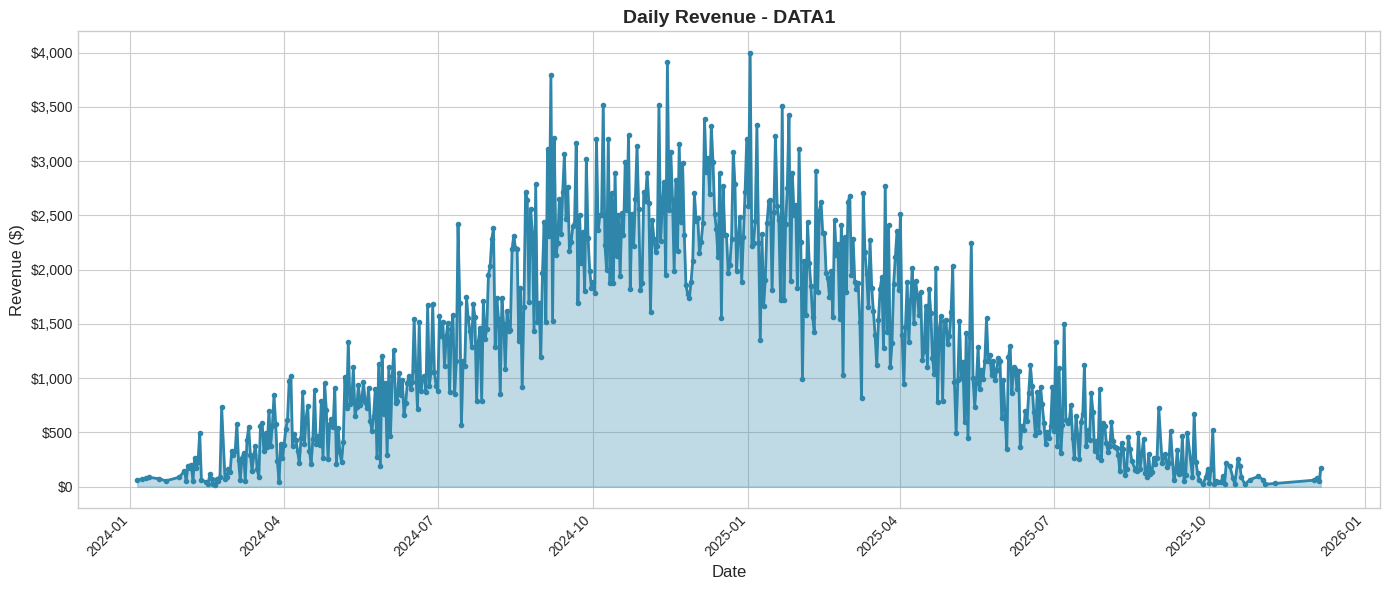

In [11]:
results_data1 = analyze_dataset('DATA1')

## 4. Analyze DATA2


ANALYZING DATA2

Loaded 2810 users from data/DATA2
Loaded 2810 users from data/DATA2
Loaded 741 books from data/DATA2
Parsing timestamps (this may take a moment)...
Loaded 741 books from data/DATA2
Parsing timestamps (this may take a moment)...
Loaded 9850 orders from data/DATA2
  - Successfully parsed prices: 9850
  - Successfully parsed timestamps: 9850

📊 TOP 5 DAYS BY REVENUE:
   2024-09-12: $4,048.85
   2024-11-15: $3,677.17
   2024-11-21: $3,590.09
   2024-12-25: $3,572.11
   2025-01-20: $3,561.51
Loaded 9850 orders from data/DATA2
  - Successfully parsed prices: 9850
  - Successfully parsed timestamps: 9850

📊 TOP 5 DAYS BY REVENUE:
   2024-09-12: $4,048.85
   2024-11-15: $3,677.17
   2024-11-21: $3,590.09
   2024-12-25: $3,572.11
   2025-01-20: $3,561.51

👥 UNIQUE USERS:
   Total user records: 2810
   Unique real users: 2663

📚 UNIQUE AUTHOR SETS: 293

⭐ MOST POPULAR AUTHOR(S):
   Jaimie Skiles (146 books sold)

💰 TOP CUSTOMER:
   User IDs: [53583, 55058, 55420]
   Total spend

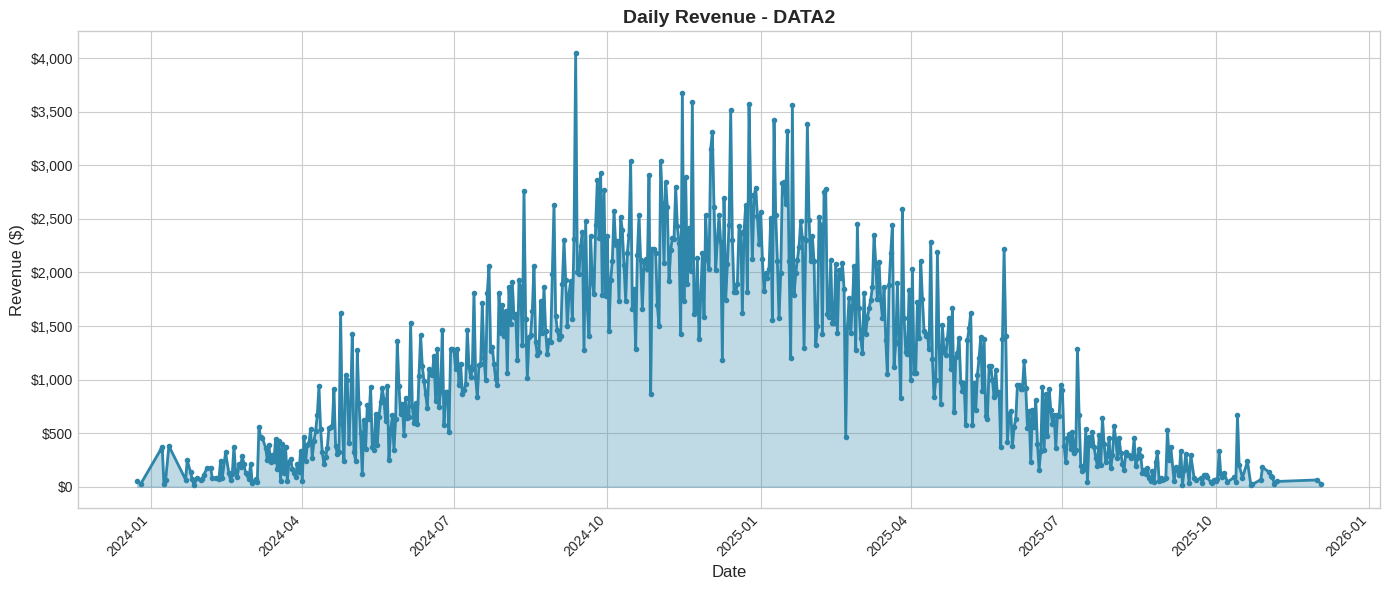

In [12]:
results_data2 = analyze_dataset('DATA2')

## 5. Analyze DATA3


ANALYZING DATA3

Loaded 3466 users from data/DATA3
Loaded 3466 users from data/DATA3
Loaded 762 books from data/DATA3
Parsing timestamps (this may take a moment)...
Loaded 762 books from data/DATA3
Parsing timestamps (this may take a moment)...
Loaded 8933 orders from data/DATA3
  - Successfully parsed prices: 8933
  - Successfully parsed timestamps: 8933

📊 TOP 5 DAYS BY REVENUE:
   2024-11-16: $3,688.20
   2025-01-31: $3,341.99
   2024-10-26: $3,127.92
   2024-11-12: $3,034.54
   2024-11-01: $2,954.03
Loaded 8933 orders from data/DATA3
  - Successfully parsed prices: 8933
  - Successfully parsed timestamps: 8933

📊 TOP 5 DAYS BY REVENUE:
   2024-11-16: $3,688.20
   2025-01-31: $3,341.99
   2024-10-26: $3,127.92
   2024-11-12: $3,034.54
   2024-11-01: $2,954.03

👥 UNIQUE USERS:
   Total user records: 3466
   Unique real users: 3290

📚 UNIQUE AUTHOR SETS: 268

⭐ MOST POPULAR AUTHOR(S):
   Benjamin Mills (156 books sold)

💰 TOP CUSTOMER:
   User IDs: [49715, 50963]
   Total spending: $

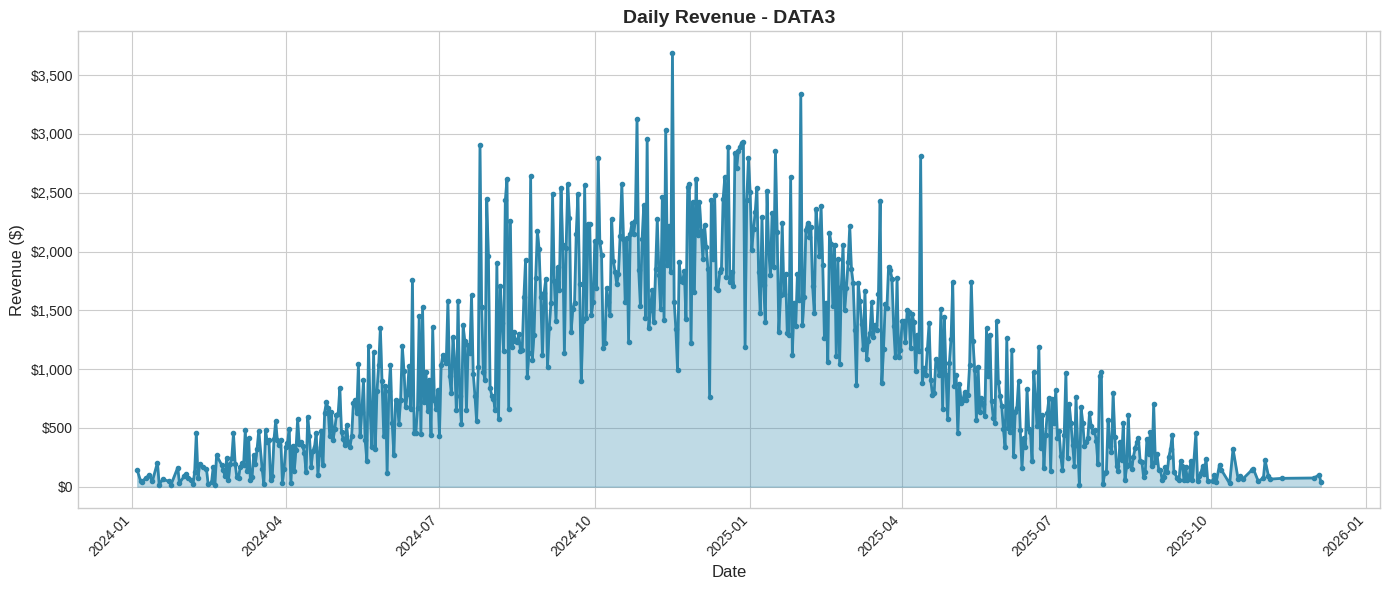

In [13]:
results_data3 = analyze_dataset('DATA3')

## 6. Summary of All Results

In [14]:
all_results = [results_data1, results_data2, results_data3]

print("\n" + "="*80)
print("SUMMARY OF ALL RESULTS")
print("="*80)

for result in all_results:
    print(f"\n{'='*40}")
    print(f"📊 {result['folder']}")
    print(f"{'='*40}")
    print(f"1. Top 5 Days by Revenue: {result['top_5_days']}")
    print(f"2. Number of Unique Users: {result['unique_users']}")
    print(f"3. Number of Unique Author Sets: {result['unique_author_sets']}")
    print(f"4. Most Popular Author(s): {result['most_popular_author']}")
    print(f"5. Top Customer IDs: {result['top_customer_ids']}")
    print(f"   Total Spending: ${result['top_customer_spending']:,.2f}")


SUMMARY OF ALL RESULTS

📊 DATA1
1. Top 5 Days by Revenue: ['2025-01-02', '2024-11-14', '2024-09-06', '2024-11-09', '2024-10-07']
2. Number of Unique Users: 3115
3. Number of Unique Author Sets: 325
4. Most Popular Author(s): ['Arlinda Huel']
5. Top Customer IDs: [44850, 45062, 46955]
   Total Spending: $1,386.76

📊 DATA2
1. Top 5 Days by Revenue: ['2024-09-12', '2024-11-15', '2024-11-21', '2024-12-25', '2025-01-20']
2. Number of Unique Users: 2663
3. Number of Unique Author Sets: 293
4. Most Popular Author(s): ['Jaimie Skiles']
5. Top Customer IDs: [53583, 55058, 55420]
   Total Spending: $1,312.84

📊 DATA3
1. Top 5 Days by Revenue: ['2024-11-16', '2025-01-31', '2024-10-26', '2024-11-12', '2024-11-01']
2. Number of Unique Users: 3290
3. Number of Unique Author Sets: 268
4. Most Popular Author(s): ['Benjamin Mills']
5. Top Customer IDs: [49715, 50963]
   Total Spending: $1,207.48


## 7. Export Results for Dashboard

Save results to JSON file for use in the web dashboard.

In [15]:
import json

# Prepare data for JSON export
dashboard_data = {}

for result in all_results:
    folder = result['folder']
    
    # Convert daily revenue to list of dicts for JSON
    daily_rev = result['daily_revenue'].copy()
    daily_rev['date'] = pd.to_datetime(daily_rev['date']).dt.strftime('%Y-%m-%d')
    
    dashboard_data[folder] = {
        'top_5_days': result['top_5_days'],
        'top_5_revenue': [round(r, 2) for r in result['top_5_revenue']],
        'unique_users': int(result['unique_users']),
        'unique_author_sets': int(result['unique_author_sets']),
        'most_popular_author': result['most_popular_author'],
        'top_customer_ids': [int(x) for x in result['top_customer_ids']],
        'top_customer_spending': round(result['top_customer_spending'], 2),
        'daily_revenue': {
            'dates': daily_rev['date'].tolist(),
            'values': [round(v, 2) for v in daily_rev['revenue'].tolist()]
        }
    }

# Save to JSON file
with open('dashboard_data.json', 'w') as f:
    json.dump(dashboard_data, f, indent=2)

print("Results exported to dashboard_data.json")
print("\nJSON Preview:")
print(json.dumps(dashboard_data, indent=2)[:2000] + "...")

Results exported to dashboard_data.json

JSON Preview:
{
  "DATA1": {
    "top_5_days": [
      "2025-01-02",
      "2024-11-14",
      "2024-09-06",
      "2024-11-09",
      "2024-10-07"
    ],
    "top_5_revenue": [
      3997.07,
      3911.99,
      3796.12,
      3518.62,
      3517.02
    ],
    "unique_users": 3115,
    "unique_author_sets": 325,
    "most_popular_author": [
      "Arlinda Huel"
    ],
    "top_customer_ids": [
      44850,
      45062,
      46955
    ],
    "top_customer_spending": 1386.76,
    "daily_revenue": {
      "dates": [
        "2024-01-05",
        "2024-01-08",
        "2024-01-10",
        "2024-01-12",
        "2024-01-18",
        "2024-01-22",
        "2024-01-30",
        "2024-02-02",
        "2024-02-03",
        "2024-02-04",
        "2024-02-05",
        "2024-02-06",
        "2024-02-07",
        "2024-02-08",
        "2024-02-09",
        "2024-02-10",
        "2024-02-11",
        "2024-02-12",
        "2024-02-15",
        "2024-02-16